$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [1]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D

# scientific
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;
import sklearn.mixture;

# ipython
import IPython;

# python
import os;
import random;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, 
                         (x.size[1]*percent)//100), 
                        PIL.Image.ANTIALIAS);



# EECS 445:  Machine Learning

## Lecture 14:  Unsupervised Learning: PCA and Clustering

- Instructor:  **Jacob Abernethy**
- Date:  November 2, 2016


## Midterm exam information

Statistics:
<span>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Total Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>141.0</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>48.7</td>
    </tr>
    <tr>
      <th>std</th>
      <td>12.4</td>
    </tr>
    <tr>
      <th>min</th>
      <td>15.0</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>40.0</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>50.0</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>58.0</td>
    </tr>
    <tr>
      <th>max</th>
      <td>72.0</td>
    </tr>
  </tbody>
</table>
</span>

## Score histogram

<img src="images/midterm_dist.png">


## Announcements

- We will be updating the HW4 to give you all an extra week
- We will add a "free form" ML challenge via Kaggle as well
- Want a regrade on the midterm? We'll post a policy soon.

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.

## Goal Today: Methods for *Unsupervised* Learning

We generally a call a problem "Unsupervised" when we don't have any labels!

## Outline

- Principle Component Analysis
    - Classical View
    - Low dimensional representation of data
    - Relationship to SVD
- Clustering
    - Core idea behind clustering
    - K-means algorithm
    - K-means++ etc.

# Principal Components Analysis

> Uses material from **[MLAPP]** and **[PRML]**

### Dimensionality Reduction

High-dimensional data may have **low-dimensional structure**.
- We only need two dimensions to describe a rotated plane in 3d!

In [2]:
def plot_plane():
    # random samples
    n = 200;
    data = np.random.random((3,n));
    data[2,:] = 0.4 * data[1,:] + 0.6 * data[0,:];
    
    # plot plane
    fig = plt.figure(figsize=(10,6));
    ax = fig.add_subplot(111, projection="3d");
    ax.scatter(*data);

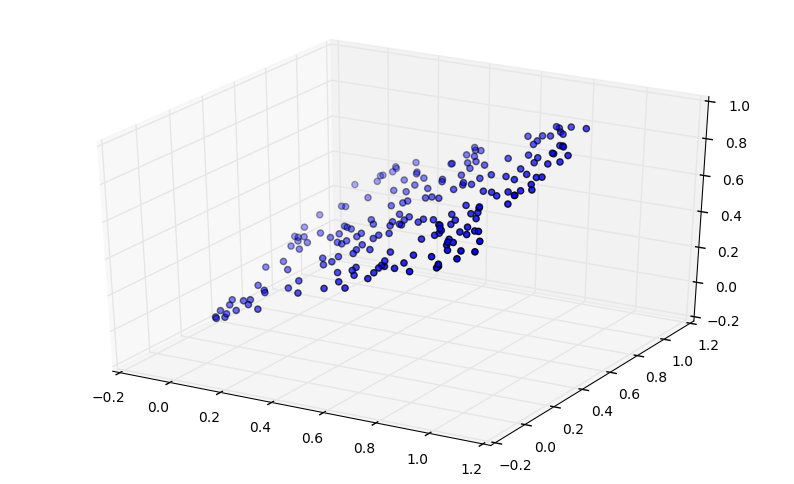

In [3]:
plot_plane()

### Dimensionality Reduction

Data may even be embedded in a low-dimensional **nonlinear manifold**.
- How can we recover a low-dimensional representation?

<img src="images/swiss-roll.png">

### Dimensionality Reduction

As an even more extreme example, consider a dataset consisting of the same image translated and rotate in different directions:
- Only 3 degrees of freedom for a 100x100-dimensional dataset!

<img src="images/pca_1.png" align="middle">

### Principal Components Analysis

Given a set $X = \{x_n\}$ of observations 
* in a space of dimension $D$, 
* find a **linear subspace** of dimension $M < D$ 
* that captures most of its variability.

PCA can be described in two equivalent ways:
* maximizing the variance of the projection, or
* minimizing the squared approximation error.

### PCA:  Equivalent Descriptions

Maximize variance or minimize squared projection error:
    
<img src="images/pca_2.png" height = "300px" width = "300px"  align="middle">

### PCA:  Equivalent Descriptions

With mean at the origin $ c_i^2 = a_i^2 + b_i^2 $, with constant $c_i^2$

* Minimizing $b_i^2$ maximizes $a_i^2$ and vice versa

<img src="images/pca_3.png" height = "300px" width = "300px"  align="middle">

### PCA:  First Principal Component

Given data points $\{x_n\}$ in $D$-dim space.
* Mean $\bar x = \frac{1}{N} \sum_{n=1}^{N} x_n $
* Data covariance ($D \times D$ matrix): 
     $ S = \frac{1}{N} \sum_{n=1}^{N}(x_n - \bar x)(x_n - \bar x)^T$

Let $u_1$ be the **principal component** we want.
* Unit length $u_1^T u_1 = 1$
* Projection of $x_n$ is $u_1^T x_n$

### PCA:  First Principal Component

**Goal:** Maximize the projection variance over directions $u_1$:
    $$ \frac{1}{N} \sum_{n=1}^{N}\{u_1^Tx_n - u_1^T \bar x \}^2 = u_1^TSu_1$$


* Use a Lagrange multiplier to enforce $u_1^T u_1 = 1$
     - Maximize: $u_1^T S u_1 + \lambda(1-u_1^T u_1)$

* Derivative is zero when $ Su_1 = \lambda u_1$
    * That is, $u_1^T S u_1 = \lambda $

* So $u_1$ is eigenvector of $S$ with largest eigenvalue.

### PCA:  Maximizing Variance

The top $M$ eigenvectors of the empirical covariance matrix $S$ give the $M$ principal components of the data.
- Minimizes squared projection error
- Maximizes projection variances

**Recall:** These are the top $M$ left singular vectors of the data matrix $\hat X$, where $\hat X := X - \bar x \mathbb{1}_N$, i.e. we shift $X$ to ensure 0-mean rows. 


## Key points for computing SVD

$$\def\bX{\bar X}$$

Let $X$ be the $n \times m$ data matrix ($n$ rows, one for each example). We want to represent our data using only the top $k$ principle components.
1. Mean-center the data, so that $\bX$ is $X$ with each row subtracted by the mean row $\frac 1 n \sum_i X_{i:}$
1. Compute the SVD of $\bX$, i.e. $\bX = U \Sigma V^\top$
1. We can construct $\Sigma_k$ which drops all but the top $k$ singular values from $\Sigma$
1. We can represent $\bX$ either in terms of the principle components, $\Sigma_k V^\top$ or we can look at the data in the original representation after dropping the lower components, which is $U \Sigma_k V^\top$

### Example:  Eigenfaces

<img src="images/pca_9.png"  align="middle">

### Example:  Face Recognition via Eigenfaces

In [4]:
## scikit example: Faces recognition example using eigenfaces and SVMs

from __future__ import print_function

from time import time
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

#print("Extracting the top %d eigenfaces from %d faces"
#      % (n_components, X_train.shape[0]))
#t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
#print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

#print("Projecting the input data on the eigenfaces orthonormal basis")
#t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
#print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

#print("Fitting the classifier to the training set")
#t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
#print("done in %0.3fs" % (time() - t0))
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

#print("Predicting people's names on the test set")
#t0 = time()
y_pred = clf.predict(X_test_pca)
#print("done in %0.3fs" % (time() - t0))

#print(classification_report(y_test, y_pred, target_names=target_names))
#print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]



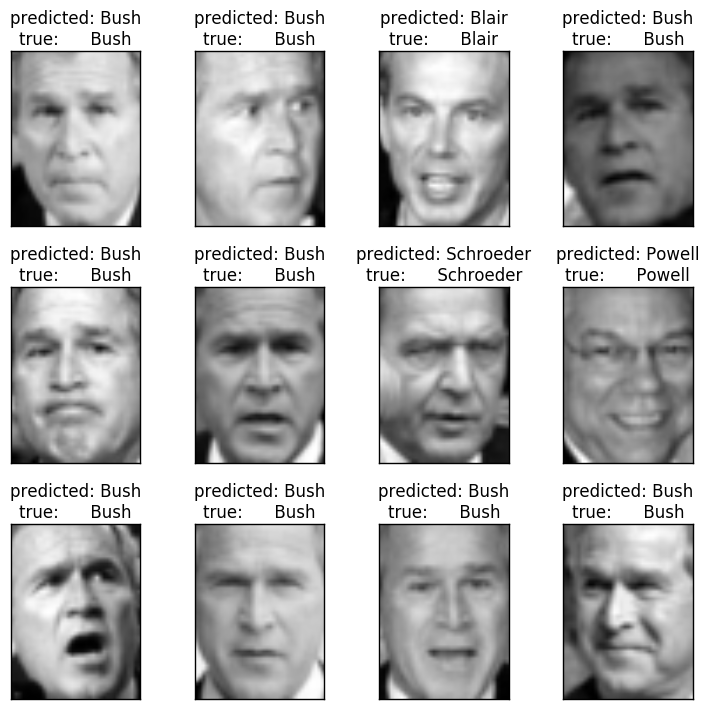

In [5]:
plot_gallery(X_test, prediction_titles, h, w)

### Example:  Face Recognition

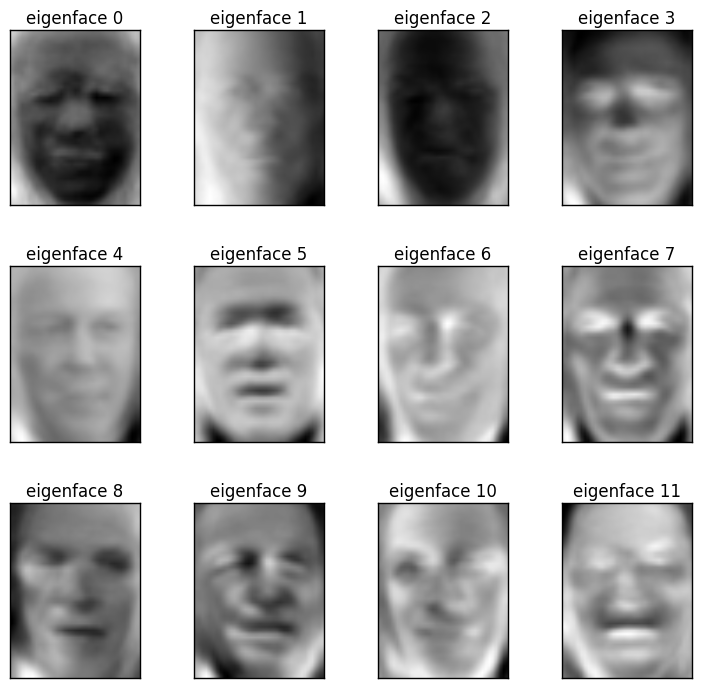

In [6]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

## Break time!

<img src="images/finger_cat.gif"/>

# Soon to come: Latent Variable Models

> Uses material from **[MLAPP]** §10.1-10.4, §11.1-11.2

### Latent Variable Models

In general, the goal of probabilistic modeling is to 
> Use what we know to make *inferences* about what we don't know.

**Graphical models** provide a natural framework for this problem.
- Assume unobserved variables are correlated due to the influence of unobserved **latent variables**.
- Latent variables encode beliefs about the generative process.


### Example to Come:  Gaussian Mixture Models

This dataset is hard to explain with a single distribution.
- Underlying density is complicated overall...
- But it's clearly three Gaussians!

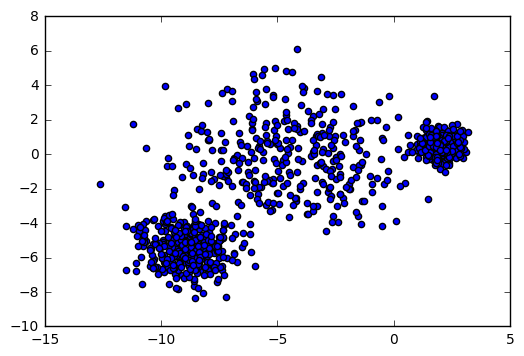

In [7]:
X, y = skl.datasets.make_blobs(1000, cluster_std=[1.0, 2.5, 0.5], random_state=170)
plt.scatter(X[:,0], X[:,1])

# Clustering & K-Means

> Uses material from **[PRML]** §9.1

### Clustering:  Introduction

**Goal:** Partition data $\X = \{ x_1, \dots, x_n \} \subset \R^d$ into $K$ disjoint **clusters**.
- Points within a cluster should be more similar to each other than to points in other clusters.
- Estimate **cluster centers** $\mu_k \in \R^d$ for $k=1,\dots,K$
- Estimate **cluster assignments** $z_j \in \{1,\dots,K\}$ for each point $x_j$

Usually, we fix $K$ beforehand!  Use model selection to overcome this limitation.

### K-Means Clustering

The **K-Means** algorithm takes a simple, non-probabilistic approach.
- First, pick random cluster centers $\mu_k$.

Then, repeat until convergence:

<div style="margin:10px; padding: 10px; border: 2px solid black">
**E-Step:** Assign $x_j$ to the nearest cluster center $\mu_k$,
$$
z_j = \arg\min_k || x_j - \mu_k ||^2
$$

**M-Step:** Re-estimate cluster centers by averaging over assignments:
$$
\mu_k = \frac{1}{ \# \{ j \mid z_j =k \}} \sum_{j=1}^N x_j \mathbb{I}(z_j = k)
$$
</div>

### K-Means Clustering: Initialization

> Images taken from Bishop, **[PRML]**

<img src="images/kmeans-1.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-2.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-3.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-4.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-5.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-6.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-7.png">

### K-Means Clustering: E-Step

<img src="images/kmeans-8.png">

### K-Means Clustering: M-Step

<img src="images/kmeans-9.png">

### K-Means:  Cluster Geometry

Clusters are convex *nearest-neighbor* regions or **Vornoi Cells**.
- Piecewise-linear boundaries

K-means will fail to identify non-convex clusters.
- However, **kernelized K-means** is possible!

<img src="images/voronoi.jpg">

### K-Means Clustering:  Analysis

*Exercise:* Show that the K-Means algorithm finds a local minimum of the **distortion measure**, given by
$$
J(\mu_1, \ldots, \mu_k; z_1, \ldots, z_N) = \sum_{j=1}^N \sum_{k=1}^K \mathbb{I}(z_j=k) || x_j - \mu_k ||^2
$$

### K-Means:  Variants

K-Means is simple and easy to extend:

- **K-Means++:** Intelligently pick initial cluster centers
- **K-Means--:** Handle outliers
- **Nonparametric K-Means:** Automatically select number of clusters
- **Kernelized K-Means:** Non-convex clusters

Next lecture, we will cover **probabilistic clustering** through the use of mixture models.

### Variant:  [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)

Instead of initializing cluster centers randomly,

<div style="margin:10px; padding: 10px; border: 2px solid black">
<ol>
<li> Choose the first cluster center to be a random datapoint.
<li>Repeat until $K$ cluster centers have been selected:
    <ol>
    <li>For each datapoint $x_j$, compute distance $D(x_j)$ to nearest cluster.
    <li>Choose data point $x_j$ at random to be the new cluster center, with probability proportional to $D(x_j)^2$.
    </ol>
<li> Run K-means as usual. 
</ol>
</div>

### Variant:  [K-Means--](http://pmg.it.usyd.edu.au/outliers.pdf)

Vanilla K-Means is sensitive to outliers.  Instead, assume there are $\ell$ outliers, then

<div style="margin:10px; padding: 10px; border: 2px solid black">
<ol>
<li> Choose initial cluster centers as usual.
<li> For $k=1,2,\dots$:
    <ol>
    <li> For each datapoint $x_j$, compute distance $D(x_j)$ to nearest cluster.
    <li> Set $L_k$ to be the $\ell$ datapoints farthest from any cluster.
    <li> Perform the E and M steps as usual on $X \setminus L_k$.
    </ol>
<li> Return most recent outlier estimate $L_k$ in addition to usual cluster data.
</ol>
</div>

### Variant: [Nonparametric K-Means](http://www.cs.berkeley.edu/~jordan/papers/kulis-jordan-icml12.pdf)

Automatically add new clusters via a **maximum cluster radius** $\lambda$.

<div style="margin:10px; padding: 10px; border: 2px solid black">
<ol>
<li> Init $K=1$ and set $\mu_1$ to be the mean over datapoints.
<li> Repeat until convergence:
    <ol>
    <li> For each point $x_j$,
        <ol>
        <li> Compute distance $D(x_j)$ to nearest cluster.
        <li> If $D(x_j) > \lambda$, increment $K$ and create a new cluster centered at $x_j$.
        <li> Otherwise, assign $x_j$ to a cluster as usual.
        </ol>
    <li> Re-estimate cluster centers as usual.
    </ol>
</ol>
</div>